In [1]:
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

### File Path to Leaf Area Index Data

In [2]:
data_path="raw/LAI_interpolated_2010_2017/LAI_201[0-6]*.nc"

### File Path to Above Ground Biomass Data (Baseline)

In [3]:
agb_data = xr.open_dataset("preprocess/agb_avitabile_2010-2016_v3.nc")

## Loading and Merging the files

### Taking the Mean for each month

We have 3 datasets for each month and we take the mean of their values to create a new dataset corresponding to the first day of each month.

In [4]:
mean_list_data=[]
data_paths = sorted(glob.glob(data_path))
for i in range(0, len(data_paths), 3):
    temp_lai = (xr.open_mfdataset(data_paths[i:i+3], parallel = True))
    lai_mean = temp_lai.mean(dim='time')
    date = data_paths[i][-11:-7] + '-' + data_paths[i][-7:-5] + '-01'
    date64 = np.datetime64(date)    
    lai_time = lai_mean.assign_coords({'time': date64})
    lai_time = lai_time.expand_dims(['time'])
    mean_list_data.append(lai_time)

In [ ]:
leaf_area_data = mean_list_data[0]
for dataset in mean_list_data:
    leaf_area_data = leaf_area_data.merge(dataset)

## Before Pre-Processing

In [6]:
print(leaf_area_data)

<xarray.Dataset>
Dimensions:  (lat: 560, lon: 1440, time: 84)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2016-12-01
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 79.38 79.62 79.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    LAI      (time, lat, lon) float32 dask.array<chunksize=(84, 560, 1440), meta=np.ndarray>
    NOBS     (time, lat, lon) float32 dask.array<chunksize=(84, 560, 1440), meta=np.ndarray>
    RMSE     (time, lat, lon) float32 dask.array<chunksize=(84, 560, 1440), meta=np.ndarray>
    QFLAG    (time, lat, lon) float32 dask.array<chunksize=(84, 560, 1440), meta=np.ndarray>


In [7]:
print(leaf_area_data.to_dataframe().describe())

/home/wikilimo/miniconda3/envs/smos-fuel-test/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/wikilimo/miniconda3/envs/smos-fuel-test/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/wikilimo/miniconda3/envs/smos-fuel-test/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/wikilimo/miniconda3/envs/smos-fuel-test/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


                LAI          NOBS          RMSE         QFLAG
count  2.015732e+07  1.760172e+07  1.732747e+07  4.694400e+07
mean   1.211667e+00  1.952494e+01  2.800187e-01  1.124925e+03
std    1.618926e+00  9.125501e+00  3.438036e-01  1.576010e+03
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    1.333320e-01  1.433333e+01  3.333300e-02  4.850000e+02
50%    5.333280e-01  1.966667e+01  1.666650e-01  4.850000e+02
75%    1.499985e+00  2.500000e+01  3.666630e-01  4.850000e+02
max    6.999930e+00  7.000000e+01  6.644378e+00  1.076667e+04


/home/wikilimo/miniconda3/envs/smos-fuel-test/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


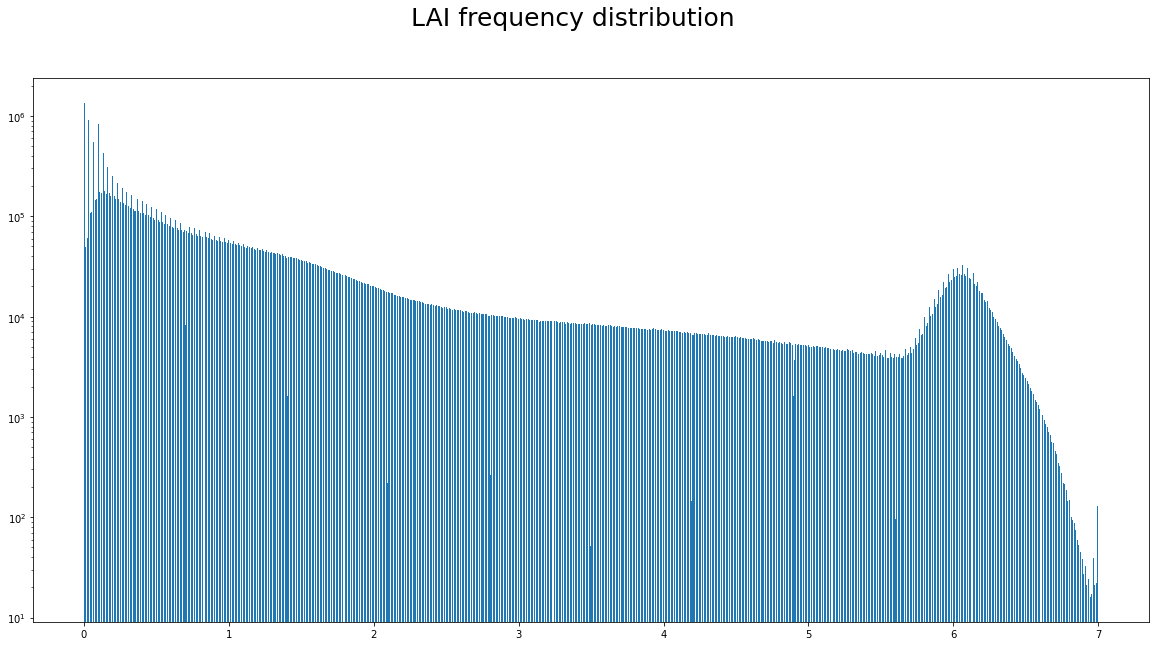

In [8]:
var_list =['LAI']
for i in range(len(var_list)):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} frequency distribution', fontsize=25)
    plt.hist(leaf_area_data[var_list[i]].values.flatten(), bins=1000, cumulative=False, log=True)

### Dropping Unwanted Features, Coordinates and rename

In [9]:
leaf_area_data = leaf_area_data.drop(["NOBS","RMSE","QFLAG"])

In [10]:
leaf_area_data = leaf_area_data.rename({"lon":"longitude","lat":"latitude"})

### Interpolating Data to match resolution of AGB

In [11]:
leaf_area_data = leaf_area_data.interp({'latitude':agb_data.latitude.values,'longitude':agb_data.longitude.values})

## After Pre-processing

In [12]:
print(leaf_area_data)

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 84)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2016-12-01
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    LAI        (time, latitude, longitude) float32 dask.array<chunksize=(84, 720, 1440), meta=np.ndarray>


In [13]:
print(leaf_area_data.to_dataframe().describe())

/home/wikilimo/miniconda3/envs/smos-fuel-test/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


                LAI
count  1.918567e+07
mean   1.196759e+00
std    1.605182e+00
min    0.000000e+00
25%    1.444430e-01
50%    5.222170e-01
75%    1.466652e+00
max    6.999930e+00


/home/wikilimo/miniconda3/envs/smos-fuel-test/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


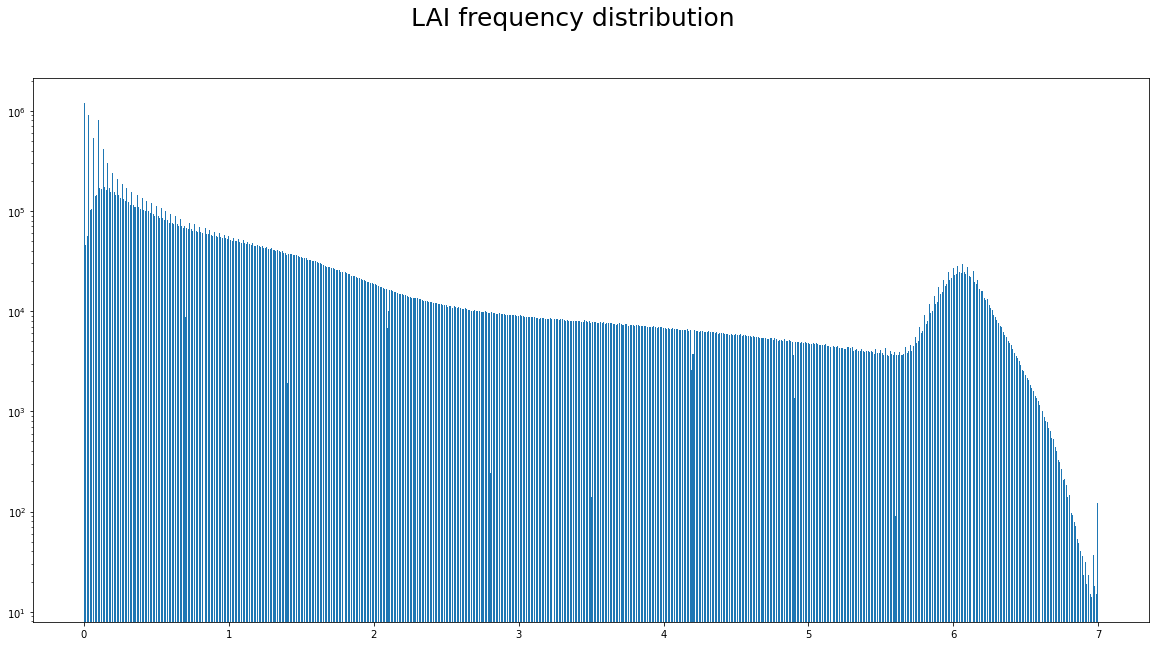

In [14]:
var_list =['LAI']
for i in range(len(var_list)):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} frequency distribution', fontsize=25)
    plt.hist(leaf_area_data[var_list[i]].values.flatten(), bins=1000, cumulative=False, log=True)

### Sanity Check

/home/wikilimo/miniconda3/envs/smos-fuel-test/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


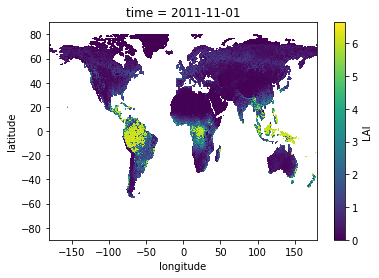

In [15]:
random_date = "201" + str(np.random.randint(0,6)) + "-" + str(np.random.randint(1, 12)) + "-01T00:00:00.000000000"
leaf_area_data.sel(time=random_date).LAI.plot()

### Saving Data

In [16]:
leaf_area_data.to_netcdf("preprocess/LAI_monthly_2010-2016_v2.nc")

/home/wikilimo/miniconda3/envs/smos-fuel-test/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## FIle Size in MB

In [17]:
round(os.stat("preprocess/LAI_monthly_2010-2016_v2.nc").st_size / (1024 * 1024), 3)

332.244